Binned Output: 0       0
1       0
2       0
3       0
4       0
       ..
1121    3
1122    3
1123    3
1124    3
1125    3
Name: binned_output, Length: 1126, dtype: int64
Entropy: 1.8039498385620911
Gini Index: 0.689909738807265
Best Root Node Feature: output
Decision Tree: {'output': {0.0: 0, 0.25: 0, 0.375: 0, 0.5: 0, 0.625: 0, 0.75: 0, 0.875: 0, 1.0: 0, 1.125: 0, 1.15625: 0, 1.1875: 0, 1.25: 1, 1.5: 1, 1.5625: 1, 1.625: 1, 1.65: 1, 1.75: 1, 1.875: 1, 2.0: 1, 2.125: 1, 2.25: 1, 2.3125: 1, 2.3333333333333335: 1, 2.375: 1, 2.4375: 1, 2.5: 2, 2.5416666666666665: 2, 2.5625: 2, 2.625: 2, 2.65625: 2, 2.6607142857142856: 2, 2.6666666666666665: 2, 2.6875: 2, 2.75: 2, 2.875: 2, 2.90625: 2, 2.9166666666666665: 2, 2.9375: 2, 3.0: 2, 3.125: 2, 3.21875: 2, 3.25: 2, 3.3125: 2, 3.34375: 2, 3.375: 2, 3.4166666666666665: 2, 3.4583333333333335: 2, 3.5: 2, 3.59375: 2, 3.625: 2, 3.6875: 2, 3.75: 3, 3.875: 3, 3.9375: 3, 4.0: 3, 4.125: 3, 4.166666666666667: 3, 4.25: 3, 4.333333333333333: 3, 4.375: 3, 4.

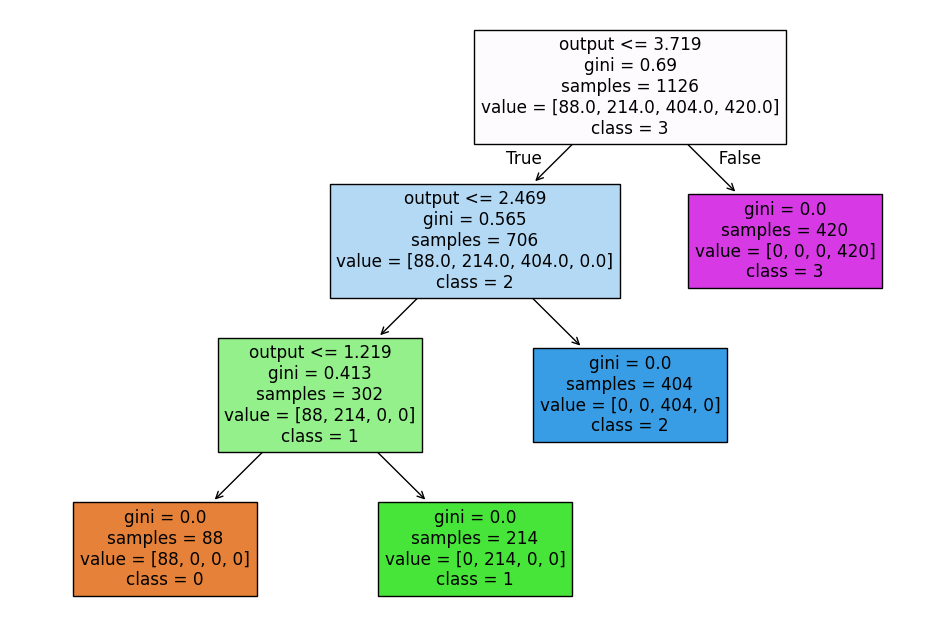

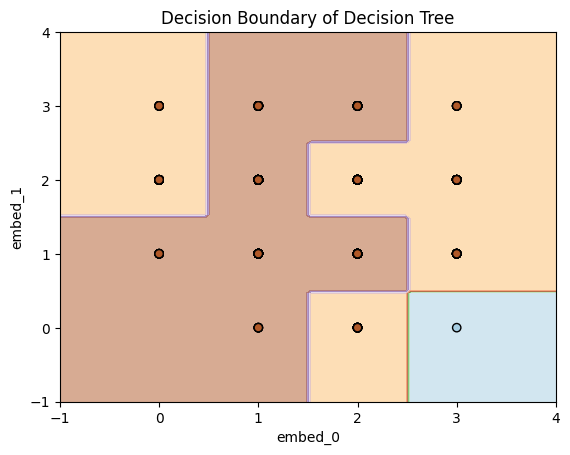

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.preprocessing import LabelEncoder

def load_dataset(file_path):
    """
    Load the dataset from an Excel file.
    """
    return pd.read_excel(file_path)

#A1
def binning(data, num_bins=4, binning_type='equal_width'):
    """Performs equal width binning or equal_frequency binning on a continuous numerical column."""
    if binning_type == 'equal_width':
        min_val, max_val = min(data), max(data)
        bin_width = (max_val - min_val) / num_bins
        bins = [min_val + i * bin_width for i in range(1, num_bins)]
    elif binning_type == 'equal_frequency':
        bins = np.percentile(data, np.linspace(0, 100, num_bins + 1)[1:-1])

    return np.digitize(data, bins)

def compute_probabilities(data):
    """
    Compute probabilities of unique values in a categorical dataset.
    """
    unique, counts = np.unique(data, return_counts=True)
    probabilities = counts / len(data)
    return probabilities

def calculate_entropy(data):
    """
    Calculate entropy of a categorical dataset.
    """
    probabilities = compute_probabilities(data)
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy
#A2
def calculate_gini_index(data):
    """
    Calculate the Gini Index of a categorical dataset.
    """
    probabilities = compute_probabilities(data)
    gini_index = 1 - np.sum(probabilities ** 2)
    return gini_index

#A3
def information_gain(df, feature_col, target_col):
    """
    Compute Information Gain for a given feature.
    """
    total_entropy = calculate_entropy(df[target_col])
    unique_values = df[feature_col].unique()
    weighted_entropy = 0

    for value in unique_values:
        subset = df[df[feature_col] == value][target_col]
        prob = len(subset) / len(df)
        weighted_entropy += prob * calculate_entropy(subset)

    return total_entropy - weighted_entropy

def find_best_feature(df, target_col):
    """
    Determine the best feature to use as the root node based on Information Gain.
    """
    features = df.columns.drop(target_col)
    best_feature = max(features, key=lambda feature: information_gain(df, feature, target_col))
    return best_feature

#A5
def build_tree(df, target_col, depth=0, max_depth=None):
    if len(df[target_col].unique()) == 1 or (max_depth and depth >= max_depth):
        return df[target_col].mode()[0]

    best_feature = find_best_feature(df, target_col)
    tree = {best_feature: {}}

    for value in df[best_feature].unique():
        subset = df[df[best_feature] == value]
        tree[best_feature][value] = build_tree(subset, target_col, depth + 1, max_depth)

    return tree

def predict(row, tree):
    if not isinstance(tree, dict):
        return tree

    feature = next(iter(tree))
    value = row[feature]
    return predict(row, tree[feature].get(value, np.nan))

def predict_all(df, tree):
    return df.apply(lambda row: predict(row, tree), axis=1)

#A6
def visualize_decision_tree(df, target_col):
    features = df.drop(columns=[target_col])
    target = df[target_col]
    clf = DecisionTreeClassifier()
    clf.fit(features, target)
    plt.figure(figsize=(12, 8))
    plot_tree(clf, feature_names=features.columns, class_names=np.unique(target).astype(str), filled=True)
    plt.show()

#A7
def visualize_decision_boundary(df, feature1, feature2, target_col):
    X = df[[feature1, feature2]].values
    y = df[target_col].values

    if y.dtype == 'object':
        le = LabelEncoder()
        y = le.fit_transform(y)

    clf = DecisionTreeClassifier()
    clf.fit(X, y)

    disp = DecisionBoundaryDisplay.from_estimator(
        clf, X, response_method="predict", cmap=plt.cm.Paired, alpha=0.5
    )

    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=plt.cm.Paired)
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.title("Decision Boundary of Decision Tree")
    plt.show()

# Load dataset
file_path = "/training_mathbert.xlsx"  # Update with correct path if needed
df = load_dataset(file_path)

#A1

# Perform binning on the 'output' column and store it in the DataFrame
df['binned_output'] = binning(df['output'].values, num_bins=4)
print("Binned Output:", df['binned_output'])

# Compute entropy
entropy_value = calculate_entropy(binned_output)
print("Entropy:", entropy_value)

#A2

# Compute Gini Index
gini_value = calculate_gini_index(binned_output)
print("Gini Index:", gini_value)

#A3 - #A4

# Perform binning on all numerical features except target column
for col in df.columns:
    if col != 'output' and df[col].dtype in ['int64', 'float64']:
        df[col] = binning(df[col].values, num_bins=4, binning_type='equal_width')

# Determine best root node
df['binned_output'] = binning(df['output'].values, num_bins=4)
best_root = find_best_feature(df, 'binned_output')
print("Best Root Node Feature:", best_root)

#A5

# Train decision tree
tree = build_tree(df, 'binned_output', max_depth=5)

print("Decision Tree:", tree)

#A6

visualize_decision_tree(df, 'binned_output')

#A7

# Visualize decision boundary
feature1, feature2 = df.columns[0], df.columns[1]
visualize_decision_boundary(df, feature1, feature2, 'binned_output')
